In [1]:
import pandas as pd
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy import func
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta

In [2]:
engine = create_engine("sqlite:///hawaii_weather.sqlite")

In [3]:
Base = automap_base()

In [4]:
Base.prepare(engine, reflect=True)

In [5]:
print('The hawaii_weather DB contains the following tables %r.' % Base.classes.keys())

The hawaii_weather DB contains the following tables ['measurement', 'station'].


In [6]:
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [7]:
session = Session(engine)

In [8]:
Stations.__table__

Table('station', MetaData(bind=None), Column('station_name', VARCHAR(length=255), table=<station>, primary_key=True, nullable=False), Column('location_name', VARCHAR(length=255), table=<station>), Column('latitude', NUMERIC(), table=<station>), Column('longitude', NUMERIC(), table=<station>), Column('elevation', NUMERIC(), table=<station>), schema=None)

In [9]:
Measurements.__table__

Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station_name', VARCHAR(length=255), ForeignKey('station.station_name'), table=<measurement>), Column('date', DATE(), table=<measurement>), Column('precipitation', VARCHAR(length=255), table=<measurement>), Column('temperature', NUMERIC(), table=<measurement>), schema=None)

In [10]:
# Find the latest observation, useful for doing queries on the last 12 months of data.
latest_observation = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
latest_obseration_str = latest_observation[0].strftime('%Y-%m-%d')
print('The latest observation in the data set was taken on %r.' % latest_obseration_str)

The latest observation in the data set was taken on '2017-08-23'.


In [68]:
# Return the last 12 months of precipitation observations in the data set.
precipitation_last_12 = session.query(Stations.station_name,\
                                      Stations.location_name\
                                     )\
    .join(Measurements, Stations.station_name==Measurements.station_name)\
    .add_columns(Measurements.precipitation, Measurements.date)\
    .filter(Measurements.precipitation.isnot(None))\
    .filter(Measurements.date > (latest_observation[0] - relativedelta(years=1)).strftime('%Y-%m-%d'))\
    .order_by(Measurements.date).all()

precipitation_last_12_dict = [
    dict( 
        (k,v) 
        for (k,v) 
        in zip(
            ('station_id', 'station_name', 'prcp', 'date'),
            (x[0], x[1], float(x[2]), x[3].strftime('%Y-%m-%d'))
        )
    )
    for x in precipitation_last_12
]
print('The first result from a query of the lat 12 mos of observations is %r.' % precipitation_last_12_dict[0])

The first result from a query of the lat 12 mos of observations is {'station_id': 'USC00519397', 'station_name': 'WAIKIKI 717.2, HI US', 'prcp': 0.08, 'date': '2016-08-24'}.


In [12]:
# Return a count of the stations in the data set.
station_count = session.query(Stations.station_name).count()
station_count
print('The number of weather stations in the hawaii_weather DB DB is %r.' % station_count)

The number of weather stations in the hawaii_weather DB DB is 9.


In [13]:
# The most active stations by number of temperature observations.
most_active_sations_tmp = session.query(Stations.station_name,\
                                      Stations.location_name\
                                     )\
    .join(Measurements, Stations.station_name==Measurements.station_name)\
    .add_columns(func.count(Measurements.id).label('tmp_total'))\
    .filter(Measurements.temperature.isnot(None))\
    .group_by(Measurements.station_name).order_by(func.count(Measurements.id).desc()).all()

most_active_sations_tmp_dict = [
    dict(
        (k,v) 
        for (k,v) 
        in zip(
            ('station_id', 'station_name', 'temperature_observations'),
            (str(x[0]), str(x[1]), int(x[2]))
        )
    )
    for x 
    in most_active_sations_tmp
]

print('The least active station in terms of temperature observations is %r.' % most_active_sations_tmp_dict[-1].get('station_name'))
      

The least active station in terms of temperature observations is 'UPPER WAHIAWA 874.3, HI US'.


In [14]:
# The most active stations by number of precipitation observations, distinct from the above query because
# some of the recordings that contain temperature data have null values for precipitation, which are here filtered out.
most_active_sations_prcp = session.query(Stations.station_name, Stations.location_name)\
    .join(Measurements, Stations.station_name==Measurements.station_name)\
    .add_columns(func.count(Measurements.id).label('tmp_total'))\
    .filter(Measurements.precipitation.isnot(None))\
    .group_by(Measurements.station_name).order_by(func.count(Measurements.id).desc()).all()

most_active_sations_prcp_dict = [
    dict( 
        (k,v) 
       for (k,v) 
       in zip(
           ('station_id', 'station_name', 'precipitation_observations'),
           (str(x[0]), str(x[1]), int(x[2])) 
       ) 
    )
    for x in most_active_sations_prcp
]

print('The least active station in terms of temperature observations is %r.' % most_active_sations_prcp_dict[-1].get('station_name'))

The least active station in terms of temperature observations is 'UPPER WAHIAWA 874.3, HI US'.


In [69]:
# Retrieve just the station names and details.
station_info = session.query(Stations.station_name,\
                            Stations.location_name,\
                            Stations.latitude,\
                            Stations.longitude,\
                            Stations.elevation,\
                            ).all()

stations_labels = ('station_id', 'station_name', 'latitude', 'longitude', 'elevation')

station_info_dict = [
    dict( 
        (k,v) 
        for (k,v) 
        in zip(
            stations_labels, 
            (str(x[0]), str(x[1]), float(x[2]), float(x[3]), float(x[4]))
        ) 
    )
    for x in station_info
]

In [16]:
# Find the most active station in the last 12 months. 
most_active_station_last_12_mos = session.query(Measurements.station_name, func.count(Measurements.id).label('tmp_total'))\
    .filter(Measurements.date >'2016-08-23').group_by(Measurements.station_name)\
    .order_by(func.count(Measurements.id).desc()).first()
    
print('The station with the largest number of temperature readings over the last 12 months of \
data is %r.' % most_active_station_last_12_mos[0])

The station with the largest number of temperature readings over the last 12 months of data is 'USC00519397'.


In [17]:
# Retrieve the last 12 months of temperature readings from the most active sation.
temp_measures_most_active_last_12_mos = session.query(Measurements.date, Measurements.temperature)\
    .filter(Measurements.station_name.contains(most_active_station_last_12_mos[0]))\
    .filter(Measurements.date > '2016-08-23').all()

temp_measures_most_active_last_12_mos_dict = [
    dict(
        (k,v) 
        for (k,v) 
        in zip(
            ('date', 'temp'),
            (x[0].strftime('%Y-%m-%d'), float(x[1]))
        )
    ) 
    for x 
    in temp_measures_most_active_last_12_mos]

print('The first measure from the most active station is %r.' % temp_measures_most_active_last_12_mos_dict[0])

The first measure from the most active station is {'date': '2016-08-24', 'temp': 79.0}.


/Users/jakram/anaconda/lib/python3.6/site-packages/sqlalchemy/sql/sqltypes.py:596: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  'storage.' % (dialect.name, dialect.driver))


In [18]:
trip_start = datetime.datetime(2016,9,1)
trip_return = datetime.datetime(2016,9,15)

trip_start_str = trip_start.strftime('%Y-%m-%d')
trip_return_str = trip_return.strftime('%Y-%m-%d')

trip_start_prior_year_str = (trip_start - relativedelta(years=1)).strftime('%Y-%m-%d')
trip_return_prior_year_str = (trip_return - relativedelta(years=1)).strftime('%Y-%m-%d')

In [19]:
def calc_temps(start_date, end_date):
    
    labels = ['min', 'max', 'avg']
    temperatures = session.query(func.min(Measurements.temperature),
                                 func.max(Measurements.temperature),
                                 func.avg(Measurements.temperature)
                                ).filter(Measurements.date >= start_date, Measurements.date <= end_date).all()
   
    temperatures = [float(x) for x in temperatures[0]]
    
    d = dict(
        (k, v)
        for (k, v)
        in zip(labels,temperatures))

    return d

In [20]:
calc_temps(trip_start, trip_return)

{'avg': 77.40229885057471, 'max': 84.0, 'min': 71.0}

In [21]:
def calc_normals(start_date, end_date=None):
    
    if end_date == None:
        end_date = datetime.datetime.now().strftime("%Y-%m-%d")
    else:
        end_date
    
    labels = ['date','min', 'max', 'avg']

    normals = session.query(
        Measurements.date,
        func.min(Measurements.temperature),
        func.max(Measurements.temperature),
        func.avg(Measurements.temperature)
    )\.group_by(Measurements.date)\
    .filter(Measurements.date >= start_date, Measurements.date <= end_date).all()
    
    l = [
        [x[0].strftime('%Y-%m-%d'), float(x[1]), float(x[2]), float(x[3])] 
        for x 
        in normals
    ]
    
    d = [
        dict((k,v)
             for (k,v)
             in zip(labels,x)
            )
        for x 
        in l
    ]
    
    return d

In [22]:
print('The first result for our trip dates is %r.' %calc_normals(trip_start)[0])

The first result for our trip dates is {'date': '2016-09-02', 'min': 75.0, 'max': 81.0, 'avg': 79.42857142857143}.


In [23]:
precipitation_last_12_df = pd.DataFrame(precipitation_last_12_dict)
precipitation_last_12_df = precipitation_last_12_df.set_index('date').drop(['station_id', 'station_name'],1)
precipitation_last_12_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


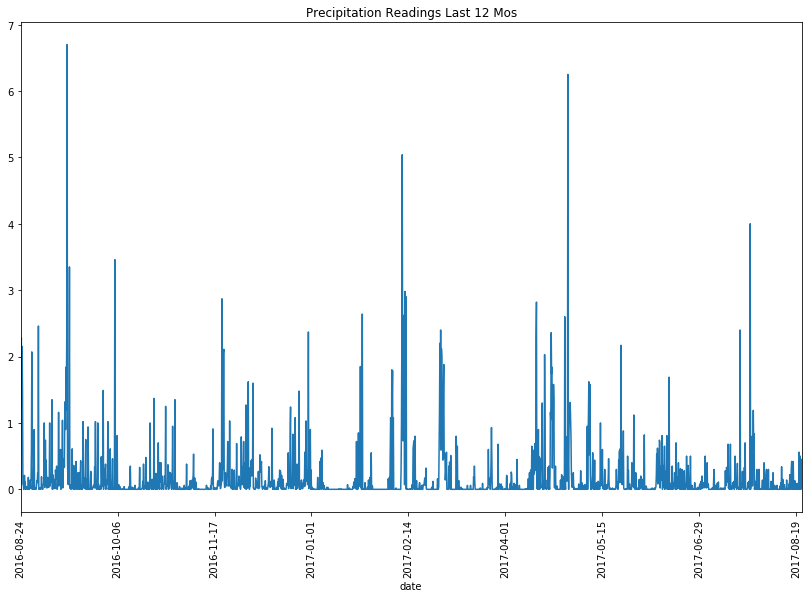

In [73]:
# Plot frequency of precipitation observations.
fig, ax = plt.subplots()

ax = precipitation_last_12_df['prcp'].plot()

plt.xticks(rotation='vertical')
ax.set_title('Precipitation Readings Last 12 Mos')
fig.set_size_inches(14, 9)

plt.show()

In [25]:
most_active_last_12_mos_df = pd.DataFrame(temp_measures_most_active_last_12_mos_dict).set_index('date')
most_active_last_12_mos_df.head()

,temp
date,
2016-08-24,79.0
2016-08-25,80.0
2016-08-26,79.0
2016-08-27,77.0
2016-08-28,78.0


In [30]:
most_active_last_12_mos_df.describe()

,temp
count,360.000000
mean,75.194444
std,4.961239
min,60.000000
25%,72.000000
50%,77.000000
75%,79.000000
max,87.000000


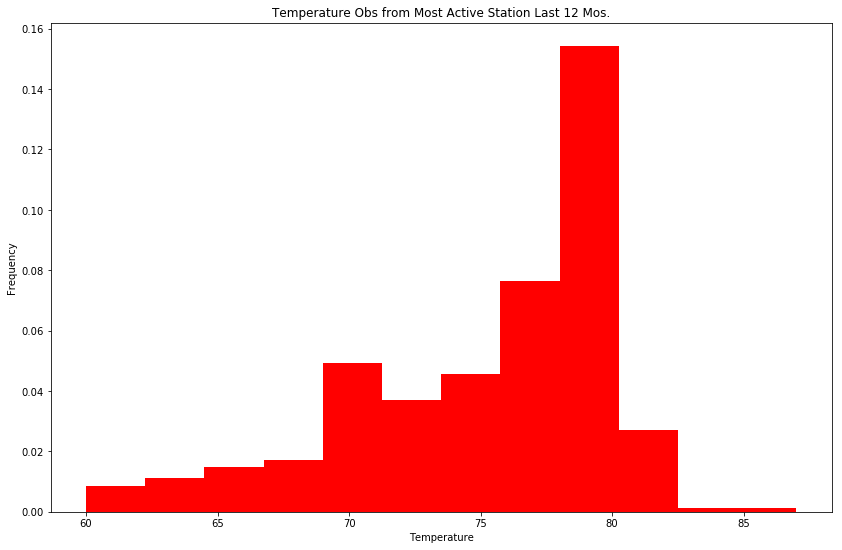

In [74]:
# Plot a histogram of temperatures of the 12 month period.
n_bins = 12
x = most_active_last_12_mos_df['temp']
color = 'red'

fig, axis = plt.subplots(nrows=1, ncols=1)
axis.hist(x, n_bins, normed=1, histtype='bar', color=color, label=color)
axis.set_title('Temperature Obs from Most Active Station Last 12 Mos.')
axis.set_xlabel('Temperature')
axis.set_ylabel('Frequency')
fig.set_size_inches(14, 9)

plt.show()

In [27]:
trip_temps = calc_temps(trip_start_prior_year_str, trip_return_prior_year_str)
trip_temps.get('avg')

78.44329896907216

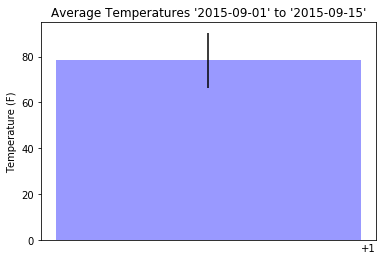

In [65]:
# Plot a single bart to show the average, min and max temperatures over the trip period minus 1 year.
height = trip_temps.get('avg')
yerr = trip_temps.get('max') - trip_temps.get('min')

fig, ax = plt.subplots()

bar_width = .001

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(
    1, 
    height, 
    bar_width,
    alpha=opacity,
    color='b',
    yerr=yerr)

ax.tick_params(
    axis='x',          
    bottom='off',
    top='off',         
    labelbottom='off') 
ax.set_title('Average Temperature %r to %r' % (
    trip_start_prior_year_str,
    trip_return_prior_year_str))
ax.set_ylabel('Temperature (F)')
plt.xticks(rotation='vertical')

plt.show()

In [34]:
trip_normals = calc_normals(trip_start, trip_return)
trip_normals_df = pd.DataFrame(trip_normals).set_index('date')
trip_normals_df.head()

,avg,max,min
date,,,
2016-09-02,79.428571,81.0,75.0
2016-09-03,77.400000,79.0,75.0
2016-09-04,77.000000,84.0,73.0
2016-09-05,79.500000,84.0,76.0
2016-09-06,75.666667,80.0,73.0


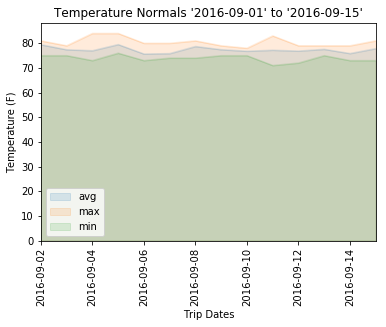

In [88]:
# Plot stacked areas to show the normals during the trip period.
# fig,ax = plt.subplots()

ax = trip_normals_df.plot.area(stacked=False, alpha=.15)

ax.set_title('Temperature Normals %r to %r' % (
    trip_start_str,
    trip_return_str))
ax.set_xlabel('Trip Dates')
ax.set_ylabel('Temperature (F)')
plt.xticks(rotation='vertical')

fig.set_size_inches(14, 9)

plt.show()